# Car price linear regression

# Feature Analysis Table

| Feature | Definition | Discussion |
|---------|------------|------------|
| Name | Brand and model of the car | Consider dropping as it's too specific for regression. Could extract brand name as a categorical feature if needed. |
| Year | Manufacturing year of the car | Requires normalization/scaling. Consider converting to 'age' feature (current_year - manufacturing_year) for better interpretation. |
| Selling_price | Price at which the car is listed for sale | Target variable. Consider log transformation if distribution is skewed to normalize the values. |
| km_driven | Total kilometers traveled by the car | Requires normalization/scaling. Strong indicator of car condition and value. |
| Fuel | Type of fuel used by the car | Binary encoding appropriate (Petrol/Diesel) after removing rare categories (LPG/CNG). Use one-hot encoding if keeping all fuel types. |
| Seller_type | Category of seller (Individual/Dealer/Trustmark Dealer) | One-hot encoding recommended as categories are nominal with no inherent order. |
| Transmission | Type of transmission (Manual/Automatic) | Binary encoding sufficient as there are only two categories. No need for one-hot encoding. |
| Owner | Number of previous owners | Ordinal encoding recommended (First=1, Second=2, Third=3) as there's a natural hierarchy that correlates with value. |
| Mileage | Fuel efficiency (kmpl) | Extract numeric values only (e.g., "20.0 kmpl" → 20.0). Important efficiency indicator. |
| Engine | Engine displacement in CC | Extract numeric values only (e.g., "1248 CC" → 1248). Key technical specification. |
| Max_power | Engine power in bhp | Extract numeric values only (e.g., "74 bhp" → 74). Important performance indicator. |
| Torque | Engine torque | Consider dropping due to complex parsing needs and lower correlation with price. If kept, needs standardized extraction of numeric values. |
| Seats | Number of seats in the car | Keep as is. Check for missing values and outliers. Generally stable feature with minimal preprocessing needed. |

## Task1

## 0. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
np.__version__, pd.__version__, sns.__version__, matplotlib.__version__

('1.26.4', '2.2.3', '0.13.2', '3.10.0')

## 1. Load data

In [3]:
df = pd.read_csv('../data/raw/Cars.csv')

In [4]:
# print the first rows of data
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [5]:
# Check the shape of data
df.shape

(8128, 13)

In [6]:
# Check Dtypes of input data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [7]:
# Check the column names
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

## 2. Exploratory Data Analysis

#### "Owner": As per instructions, map the first = 1, second =2, third = 3, fourth = 4 and test_drive_car to 5. 

In [8]:
# Define a custom mapping
mapping = {
    "First Owner": 1,
    "Second Owner": 2,
    "Third Owner": 3,
    "Fourth & Above Owner": 4,
    "Test Drive Car": 5
}

# Apply the mapping
df["owner"] = df["owner"].map(mapping)

# Check the results
print(df["owner"].unique())  # Output: [1, 2, 3, 4, 5]

[1 2 3 4 5]


In [9]:
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,1,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,4,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,1,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,1,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0


#### "fuel": As per instruction, drop all rows with CNG and LPG becuase they are using different mileage system. 

In [10]:
df['fuel'].unique() # check the original df['fuel']

array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [11]:
# remove the rows with fuel type CNG and LPG
df = df[df.fuel != 'CNG']
df = df[df.fuel != 'LPG'] 

In [12]:
df['fuel'].unique() # check the modified df['fuel']

array(['Diesel', 'Petrol'], dtype=object)

#### "mileage": As per instruction, remove 'kmpl' and convert column to numerial type

In [13]:
df['mileage'] # check the original df['mileage']

0        23.4 kmpl
1       21.14 kmpl
2        17.7 kmpl
3        23.0 kmpl
4        16.1 kmpl
           ...    
8123     18.5 kmpl
8124     16.8 kmpl
8125     19.3 kmpl
8126    23.57 kmpl
8127    23.57 kmpl
Name: mileage, Length: 8033, dtype: object

In [14]:
df['mileage'] = df.mileage.str.split().str[0].astype(float) # remove the kmpl from mileage and convert it to float

In [15]:
df['mileage'] # check the modified df['mileage']

0       23.40
1       21.14
2       17.70
3       23.00
4       16.10
        ...  
8123    18.50
8124    16.80
8125    19.30
8126    23.57
8127    23.57
Name: mileage, Length: 8033, dtype: float64

#### "Engine": As per instruction, remove 'CC' and convert column to numerial type

In [16]:
df['engine'] = df.engine.str.split().str[0].astype(float) # remove CC from engine and convert it to float

In [17]:
df['engine'] # check the modified df['engine']

0       1248.0
1       1498.0
2       1497.0
3       1396.0
4       1298.0
         ...  
8123    1197.0
8124    1493.0
8125    1248.0
8126    1396.0
8127    1396.0
Name: engine, Length: 8033, dtype: float64

#### "Max_power": As per instruction, remove 'bhp' and convert colum to numerial type 

In [18]:
df['max_power'] = df.max_power.str.split().str[0].astype(float) # remove bhp from max_power and convert it to float

In [19]:
df['max_power'] #  check the modified df['max_power']

0        74.00
1       103.52
2        78.00
3        90.00
4        88.20
         ...  
8123     82.85
8124    110.00
8125     73.90
8126     70.00
8127     70.00
Name: max_power, Length: 8033, dtype: float64

#### "Brand": Takes only the first word and remove the rest

In [20]:
df['name'] = df.name.str.split().str[0] # remove the model name and keep only the brand name
df.rename(columns={'name': 'brand'}, inplace=True) # rename the column name to brand

In [21]:
df

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai,2013,320000,110000,Petrol,Individual,Manual,1,18.50,1197.0,82.85,113.7Nm@ 4000rpm,5.0
8124,Hyundai,2007,135000,119000,Diesel,Individual,Manual,4,16.80,1493.0,110.00,"24@ 1,900-2,750(kgm@ rpm)",5.0
8125,Maruti,2009,382000,120000,Diesel,Individual,Manual,1,19.30,1248.0,73.90,190Nm@ 2000rpm,5.0
8126,Tata,2013,290000,25000,Diesel,Individual,Manual,1,23.57,1396.0,70.00,140Nm@ 1800-3000rpm,5.0


#### "Torque": Drops this feature according to the instruction

In [22]:
df = df.drop(['torque'], axis=1) # drop the torque column

#### "Test Drive Cars": Delete all samples related to this becuase they are very expansive and we don't wnat to involve this

In [23]:
df['owner'].unique() # check the original df['owner']

array([1, 2, 3, 4, 5])

In [24]:
df[df['owner'] == 5] # check the rows with owner = 5

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
4383,Volkswagen,2019,1350000,5400,Diesel,Dealer,Manual,5,22.27,1498.0,108.60,5.0
4950,Audi,2019,6223000,7800,Petrol,Dealer,Automatic,5,15.26,1798.0,187.74,5.0
4951,Audi,2019,5923000,11500,Petrol,Dealer,Automatic,5,15.26,1798.0,187.74,5.0
4952,Audi,2019,6523000,23600,Petrol,Dealer,Automatic,5,15.26,1798.0,187.74,5.0
6220,Honda,2019,2000000,24857,Petrol,Dealer,Automatic,5,16.50,1799.0,139.46,5.0


In [25]:
# Since they are significantly large values, so we can drop them

df = df[df.owner != 5]

In [26]:
df['owner'].unique() # check the modified df['owner']

array([1, 2, 3, 4])

### 2.1 Univariate analyis

Single variable exploratory data anlaysis

In [27]:
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0


#### Countplot

In [28]:
## Countplot - Best for categorical variables to understand frequency:
## In this case, I will be analyzed 'fuel, 'seller_type', 'transmission', 'owner', 'seats' features using countplots

<Axes: xlabel='fuel', ylabel='count'>

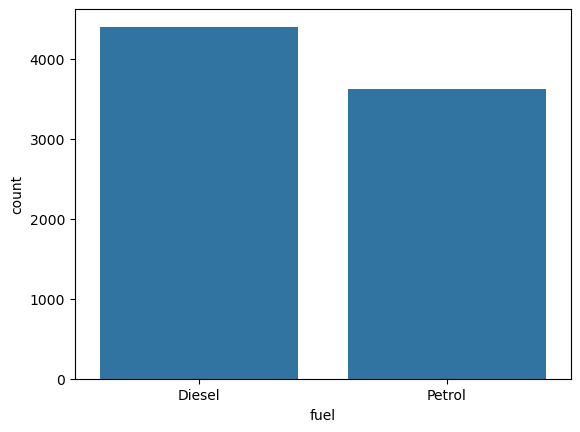

In [29]:
# Shows proportion of Diesel vs Petrol cars and it seems that they are almost equal
sns.countplot(data = df, x = 'fuel')

<Axes: xlabel='seller_type', ylabel='count'>

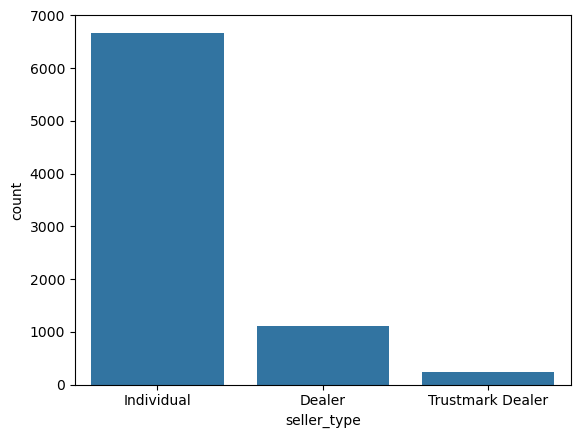

In [30]:
# We can see the individual sellers are more dominant than the other two types
sns.countplot(data = df, x = 'seller_type') 

<Axes: xlabel='transmission', ylabel='count'>

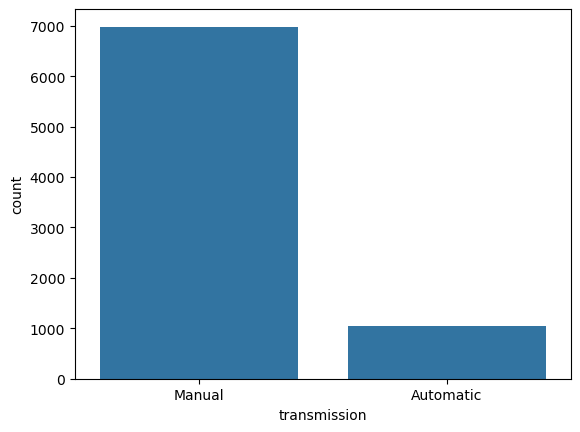

In [31]:
# we can see that manual cars are more prefrable than automatic cars in the market
sns.countplot(data = df, x = 'transmission') 

<Axes: xlabel='seats', ylabel='count'>

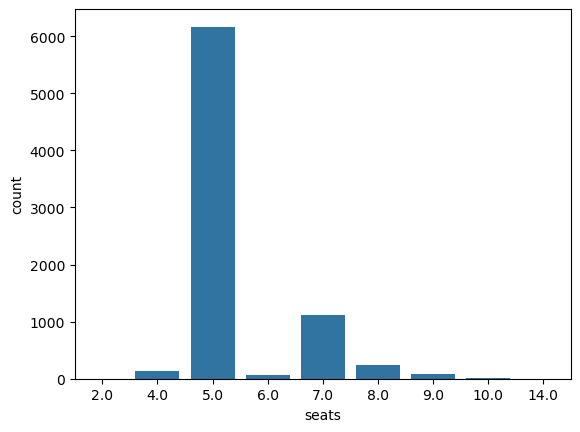

In [32]:
# we can see that most cars have 5 seats
sns.countplot(data = df, x = 'seats')

<Axes: xlabel='owner', ylabel='count'>

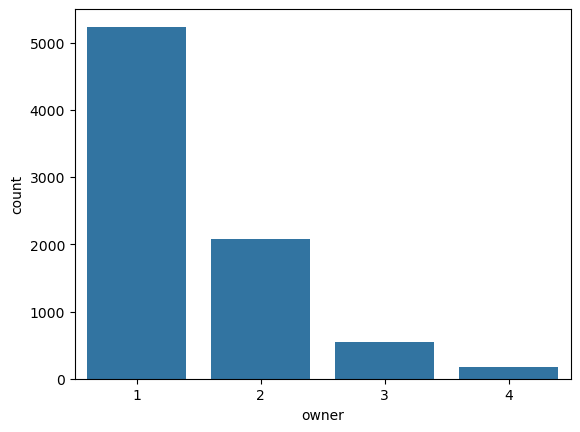

In [33]:
# we can see that most cars are first owner
sns.countplot(data = df, x = 'owner')

##### Insights: As per above analysis, we can conclude that 
 - The market is balanced between disel and pertol cars
 - Buyers preferred manual cars from indiviual sellers
 - Cars with 5 seats are dominant and First-owners cars are most wanted

#### Distribution plot

In [ ]:
# Distribution Plot - Best for continuous variables to understand their spread and patterns
# In this case, I will be analyzed 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power' features using distribution plots

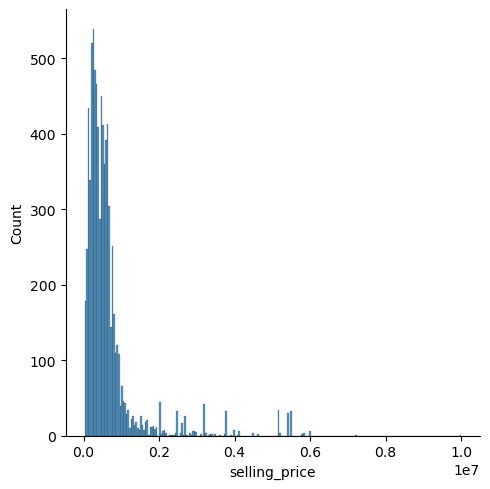

In [34]:
sns.displot(data = df, x = 'selling_price') # selling price is right skewed

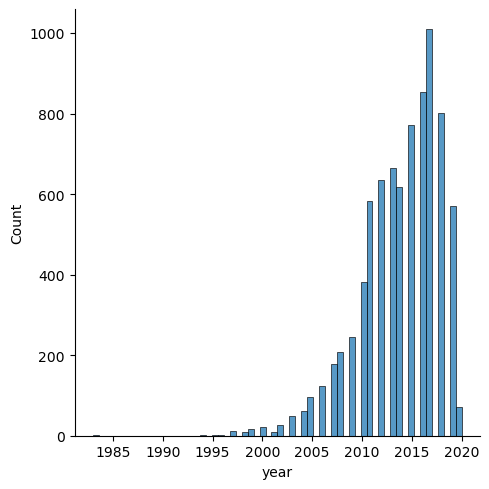

In [35]:
sns.displot(data = df, x = 'year') # selling price is right skewed

### 2.2 Multivariate analysis

Multiple variable exploratory data analysis

#### Boxplot

In [ ]:
# Let's try bar plot on "Status"
sns.boxplot(x = df["status"], y = df["life-exp"]);
plt.ylabel("Life Expectancy")
plt.xlabel("Status")

#### Scatterplot

In [ ]:
sns.scatterplot(x = df['income'], y = df['life-exp'], hue=df['status'])

#### Correlation Matrix

Let's use correlation matrix to find strong factors predicting the life expectancy.  It's also for checking whether certain features are too correlated.

In [16]:
df = df.drop('country', axis='columns')

#### Tips: Label encoding

Now we would like to change "Developing" and "Developed" to "0" and "1", since machine learning algorithms do not understand text.   Also, correlation matrix and other similar computational tools require label encoding.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["status"] = le.fit_transform(df["status"])

df["status"].unique()

In [ ]:
# we can call le.classes_ to know what it maps to
le.classes_

In [ ]:
# then we can try transform
le.transform(["Developed", "Developing"])

In [ ]:
# Let's check out heatmap
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")  #don't forget these are not all variables! categorical is not here...

## 3. Feature Engineering

Gonna skip for this assignment. 

## 4. Feature selection

In [36]:
X = df[['max_power', 'mileage','year']]

y = np.log(df['selling_price'])

In [37]:
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (8028, 3)
y: (8028,)


### Train test split

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## 5. Preprocessing

### Null values

In [42]:
X_train

,max_power,mileage,year
6853,72.40,13.58,2015
1495,62.10,15.96,2013
7904,88.76,20.77,2013
1281,90.00,18.80,2010
1421,90.00,23.00,2010
...,...,...,...
5293,78.90,20.36,2013
5461,67.04,20.51,2016
865,88.76,20.77,2015
7701,214.56,22.37,2019


In [39]:
#check for null values
X_train[['max_power', 'mileage','year']].isna().sum()

max_power    149
mileage      154
year           0
dtype: int64

In [43]:
X_test[['max_power', 'mileage','year']].isna().sum()

max_power    59
mileage      60
year          0
dtype: int64

In [44]:
y_train.isna().sum()

0

In [45]:
y_test.isna().sum()

0

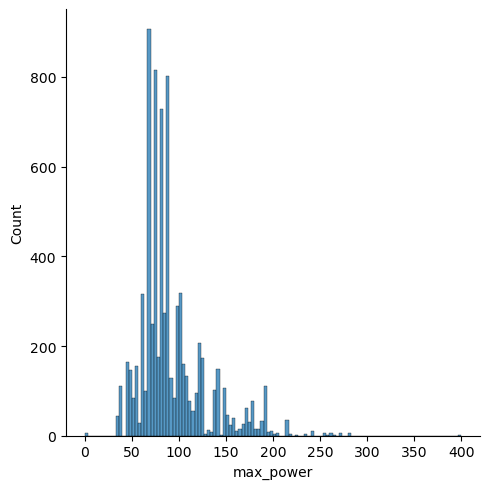

In [46]:
sns.displot(data=df, x='max_power')

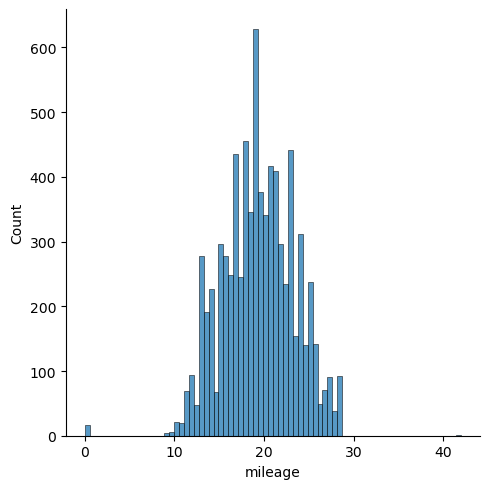

In [47]:
sns.displot(data=df, x='mileage')

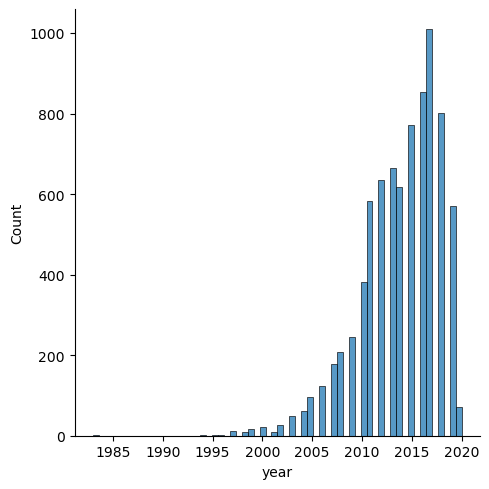

In [48]:
sns.displot(data=df, x='year')

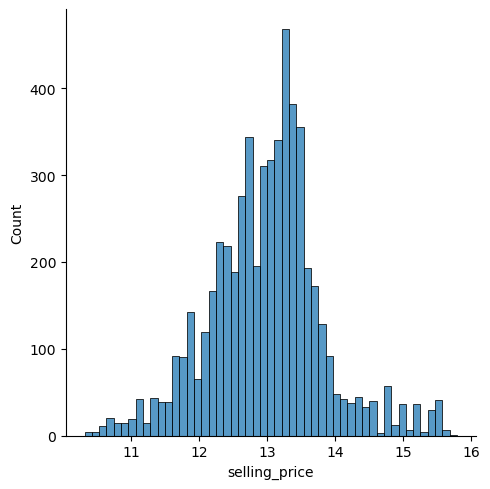

In [49]:
sns.displot(y_train)

In [50]:
# year, max_power are right skewed
# milage is almost normally distributed

In [52]:
#let's fill the training set first!
X_train['mileage'].fillna(X_train['mileage'].mean(), inplace=True)
X_train['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_train['year'].fillna(X_train['year'].median(), inplace=True)

In [53]:
#let's fill the testing set with the training distribution first!
X_test['mileage'].fillna(X_train['mileage'].mean(), inplace=True)
X_test['max_power'].fillna(X_train['max_power'].median(), inplace=True)
X_test['year'].fillna(X_train['year'].median(), inplace=True)

In [55]:
#check again
X_train[['max_power', 'mileage','year']].isna().sum()

max_power    0
mileage      0
year         0
dtype: int64

In [56]:
X_test[['max_power', 'mileage','year']].isna().sum()

max_power    0
mileage      0
year         0
dtype: int64

In [57]:
y_train.isna().sum(), y_test.isna().sum()

(0, 0)

### Checking Outliers

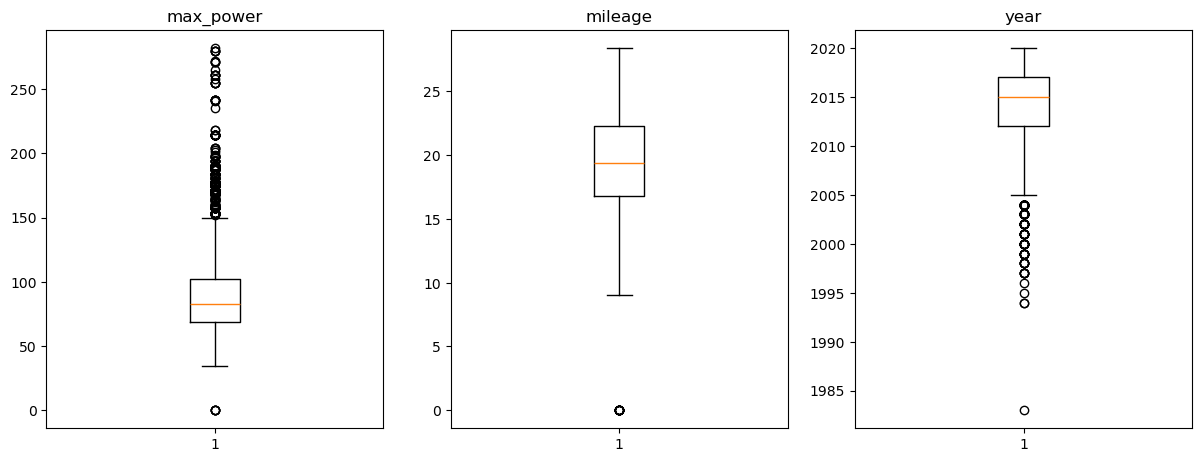

In [58]:
# Create a dictionary of columns.
col_dict = {'max_power':1, 'mileage':2 ,'year': 3}

# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for variable,i in col_dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(X_train[variable])
                     plt.title(variable)

plt.show()

In [59]:
def outlier_count(col, data = X_train):
    
    # calculate your 25% quatile and 75% quatile
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculate your inter quatile
    iqr = q75 - q25
    
    # min_val and max_val
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # count number of outliers, which are the data that are less than min_val or more than max_val calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [60]:
for col in X_train.columns:
    outlier_count(col)


---------------max_power---------------

Number of outliers: 409
Percent of data that is outlier: 7.28%

---------------mileage---------------

Number of outliers: 14
Percent of data that is outlier: 0.25%

---------------year---------------

Number of outliers: 145
Percent of data that is outlier: 2.58%


### Scaling

In [61]:
from sklearn.preprocessing import StandardScaler

# feature scaling helps improve reach convergence faster
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

#x = (x - mean) / std
#why do we want to scale our data before data analysis / machine learning

#allows your machine learning model to catch the pattern/relationship faster
#faster convergence

#how many ways to scale
#standardardization <====current way
# (x - mean) / std
#--> when your data follows normal distribution

#normalization <---another way
# (x - x_min) / (x_max - x_min)
#---> when your data DOES NOT follow normal distribution (e.g., audio, signal, image)

In [62]:
# Let's check shapes of all X_train, X_test, y_train, y_test
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (5619, 3)
Shape of X_test:  (2409, 3)
Shape of y_train:  (5619,)
Shape of y_test:  (2409,)


## 6. Modeling

In [63]:
from sklearn.linear_model import LinearRegression  #we are using regression models
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)

print("MSE: ", mean_squared_error(y_test, yhat))
print("r2: ", r2_score(y_test, yhat))

MSE:  0.113701300891246
r2:  0.8383976294188933


### Much better: Cross validation + Grid search

In [65]:
from sklearn.linear_model import LinearRegression  #we are using regression models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Libraries for model evaluation

# models that we will be using, put them in a list
algorithms = [LinearRegression(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(random_state = 0), 
              RandomForestRegressor(n_estimators = 100, random_state = 0)]

# The names of the models
algorithm_names = ["Linear Regression", "SVR", "KNeighbors Regressor", "Decision-Tree Regressor", "Random-Forest Regressor"]

Let's do some simple cross-validation here....

In [64]:
y_train.isna().sum()

0

In [66]:
from sklearn.model_selection import KFold, cross_val_score

#lists for keeping mse
train_mse = []
test_mse = []

#defining splits
kfold = KFold(n_splits=5, shuffle=True)

for i, model in enumerate(algorithms):
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print(f"{algorithm_names[i]} - Score: {scores}; Mean: {scores.mean()}")

Linear Regression - Score: [-0.1269794  -0.12008806 -0.11291722 -0.11624641 -0.11549079]; Mean: -0.11834437581732923
SVR - Score: [-0.09098385 -0.08085348 -0.08428225 -0.09235546 -0.08761494]; Mean: -0.08721799593065756
KNeighbors Regressor - Score: [-0.07172464 -0.06553557 -0.07882031 -0.06463842 -0.07306137]; Mean: -0.0707560624856624
Decision-Tree Regressor - Score: [-0.07257131 -0.07398393 -0.07332177 -0.07663721 -0.06278919]; Mean: -0.07186068105411333
Random-Forest Regressor - Score: [-0.05850565 -0.05129162 -0.05121164 -0.05769529 -0.06231497]; Mean: -0.056203834966298015


Hmm...it seems random forest do very well....how about we grid search further to find the best version of the model.

### Grid Search

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bootstrap': [True], 'max_depth': [5, 10, None],
              'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

rf = RandomForestRegressor(random_state = 1)

grid = GridSearchCV(estimator = rf, 
                    param_grid = param_grid, 
                    cv = kfold, 
                    n_jobs = -1, 
                    return_train_score=True, 
                    refit=True,
                    scoring='neg_mean_squared_error')

# Fit your grid_search
grid.fit(X_train, y_train);  #fit means start looping all the possible parameters

In [68]:
grid.best_params_

{'bootstrap': True, 'max_depth': None, 'n_estimators': 15}

In [69]:
# Find your grid_search's best score
best_mse = grid.best_score_

In [70]:
best_mse  # ignore the minus because it's neg_mean_squared_error

-0.058045945136631395

## 7. Testing


In [71]:
yhat = grid.predict(X_test)
mean_squared_error(y_test, yhat)

0.053299896795658976

## 8. Analysis:  Feature Importance

Understanding why is **key** to every business, not how low MSE we got.  Extracting which feature is important for prediction can help us interpret the results.  There are several ways: algorithm, permutation, and shap.  Note that these techniques can be mostly applied to most algorithms. 

Most of the time, we just apply all, and check the consistency.

#### Algorithm way

Some ML algorithms provide feature importance score after you fit the model

In [ ]:
#stored in this variable
#note that grid here is random forest
rf = grid.best_estimator_

rf.feature_importances_

In [ ]:
#let's plot
plt.barh(X.columns, rf.feature_importances_)

In [ ]:
#hmm...let's sort first
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Permutation way

This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one.

*Note*: The permutation based importance is computationally expensive. The permutation based method can have problem with highly-correlated features, it can report them as unimportant.

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_test, y_test)

#let's plot
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Shap way

The SHAP interpretation can be used (it is model-agnostic) to compute the feature importances. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction. It can be easily installed (<code>pip install shap</code>) 

In [54]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [ ]:
#shap provides plot
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = X.columns)

## 9. Inference

To provide inference service or deploy, it's best to save the model for latter use.

In [72]:
!pwd

/home/koala/ait/ML-Assignments/A1_KaungHtetCho/notebooks


In [73]:
import pickle

# save the model to disk
filename = '../models/car_price.model'
pickle.dump(grid, open(filename, 'wb'))

In [74]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [77]:
#let's try to create one silly example
df[['max_power', 'mileage','year']].loc[1]

max_power     103.52
mileage        21.14
year         2014.00
Name: 1, dtype: float64

In [78]:
# max_power, mileage, year
sample = np.array([[1300, 23.2, 2022]])

In [80]:
predicted_car_price = loaded_model.predict(sample)
predicted_car_price = np.exp(predicted_car_price)
predicted_car_price

array([4359782.9920812])